In [1]:
import numpy as np
import sqlite3

In [2]:
from tensorflow.keras.datasets import mnist

# Load MNIST dataset (train and test sets)
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize pixel values from 0-255 to 0-1 float range
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Flatten images from (28,28) to (784,1)
train_images = train_images.reshape((-1, 28*28)).T  # shape (784, num_train)
test_images = test_images.reshape((-1, 28*28)).T    # shape (784, num_test)

# One-hot encode the labels (0-9) into vectors of length 10
def one_hot_encode(labels, num_classes=10):
    one_hot = np.zeros((num_classes, labels.size))
    for idx, val in enumerate(labels):
        one_hot[val, idx] = 1.0
    return one_hot

train_labels_oh = one_hot_encode(train_labels)  # shape (10, num_train)
test_labels_oh = one_hot_encode(test_labels)    # shape (10, num_test)


2025-05-23 08:40:22.957898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747989623.169062      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747989623.228921      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def sigmoid(z):
    return 1/(1+np.exp(-z)) #  Converts input into a value between 0 and 1.


In [5]:
def softmax(z):
    exp_z = np.exp(z - np.max(z))  # for numerical stability
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

In [6]:
no_of_pixels= 784
hidden_layer_nodes=30
output_nodes=10 

In [7]:
np.random.seed(42)
# makes debugging and comparing to find ideal values easier
w1= np.random.randn(hidden_layer_nodes,no_of_pixels)
b1= np.random.randn(hidden_layer_nodes,1)
w2= np.random.randn(output_nodes,hidden_layer_nodes)
b2= np.random.randn(output_nodes,1)


In [8]:
def cost(y,a2): #measures how far away the predicted vaue label is from actual label
    return 0.5*np.sum(y-a2)**2 
                        

In [9]:
def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z)) # derivative of sigmoid 
                                         # used to compute the gradient of the loss function with respect to the weights of the network,

In [10]:
def training(x, y):
    global w1, b1, w2, b2
    eta = 0.01  # learning rate

    # Forward pass
    z1 = np.dot(w1, x) + b1
    a1 = sigmoid(z1)

    z2 = np.dot(w2, a1) + b2
    a2 = sigmoid(z2)

    # Backward pass (compute gradients)
    delta2 = (a2 - y) * sigmoid_prime(z2)
    dw2 = np.dot(delta2, a1.T)  
    db2 = delta2

    delta1 = np.dot(w2.T, delta2) * sigmoid_prime(z1)
    dw1 = np.dot(delta1, x.T)   
    db1 = delta1

    # Updates weights and biases
    w2 -= eta * dw2
    b2 -= eta * db2
    w1 -= eta * dw1
    b1 -= eta * db1

    # Returns cost
    cost = np.sum((a2 - y) ** 2) / 2
    return cost


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score # used to check how good its at predicitng

In [12]:
#main implementation code for number recognition algorithm
#contains code for main 4 metrics for checking performance for  machine leaning

def train_and_evaluate(train_images, train_labels_oh, test_images, test_labels_oh, epochs=100, samples=3000):
    conn = sqlite3.connect("training_log.db")    # Connect to SQLite database (or create it if it doesn't exist)

    cursor = conn.cursor()
        # Create the table to store performance metrics (if it doesn’t already exist)

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS training_log (
        epoch INTEGER,
        avg_cost REAL,
        accuracy REAL,
        precision REAL,
        recall REAL,
        f1 REAL
    )
    """)
    conn.commit()

    for epoch in range(epochs):
        total_cost = 0
        for i in range(samples):
            x = train_images[:, i].reshape(-1, 1)
            y = train_labels_oh[:, i].reshape(-1, 1)  # Get the corresponding one-hot encoded label and reshape it into a column vector

            c = training(x, y)
            total_cost += c

        avg_cost = total_cost / samples

    # Evaluation on test
        y_true = []
        y_pred = []

        for i in range(test_images.shape[1]):
            x_test = test_images[:, i].reshape(-1, 1) 
            y_actual = np.argmax(test_labels_oh[:, i])  # Get the corresponding one-hot encoded label and reshape it into a column vector


        # Inline prediction
            z1 = np.dot(w1, x_test) + b1
            a1 = sigmoid(z1)
            z2 = np.dot(w2, a1) + b2
            a2 = softmax(z2) #converts the final layer's raw outputs (called logits) into probabilities which sum to 1, highest probabilty for the output ndoes is taken as predicted class

            y_hat = np.argmax(a2) #Returns the index of the largest value in the array, we use it as the index corresponds to the numbers predicted

            y_true.append(y_actual)
            y_pred.append(y_hat)
            
    # Calculate the performance metrics

        accuracy = np.mean(np.array(y_true) == np.array(y_pred))
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

        print(f"Epoch {epoch+1} — Cost: {avg_cost:.4f}, Acc: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

     # Store results in database
        cursor.execute("""
            INSERT INTO training_log (epoch, avg_cost, accuracy, precision, recall, f1)
            VALUES (?, ?, ?, ?, ?, ?)
        """, (epoch+1, avg_cost, accuracy, precision, recall, f1))
        conn.commit()

    conn.close()


In [13]:
train_and_evaluate(train_images, train_labels_oh, test_images, test_labels_oh, epochs=100, samples=5000)


Epoch 1 — Cost: 0.6036, Acc: 0.2779, Precision: 0.1708, Recall: 0.2668, F1: 0.1967
Epoch 2 — Cost: 0.4288, Acc: 0.3129, Precision: 0.1822, Recall: 0.3013, F1: 0.2118
Epoch 3 — Cost: 0.4109, Acc: 0.3358, Precision: 0.1952, Recall: 0.3240, F1: 0.2288
Epoch 4 — Cost: 0.3971, Acc: 0.3588, Precision: 0.2134, Recall: 0.3466, F1: 0.2499
Epoch 5 — Cost: 0.3854, Acc: 0.3806, Precision: 0.2294, Recall: 0.3679, F1: 0.2727
Epoch 6 — Cost: 0.3746, Acc: 0.4068, Precision: 0.2552, Recall: 0.3934, F1: 0.2981
Epoch 7 — Cost: 0.3637, Acc: 0.4287, Precision: 0.2872, Recall: 0.4148, F1: 0.3180
Epoch 8 — Cost: 0.3527, Acc: 0.4435, Precision: 0.3156, Recall: 0.4292, F1: 0.3316
Epoch 9 — Cost: 0.3425, Acc: 0.4571, Precision: 0.3339, Recall: 0.4426, F1: 0.3449
Epoch 10 — Cost: 0.3332, Acc: 0.4719, Precision: 0.3524, Recall: 0.4572, F1: 0.3631
Epoch 11 — Cost: 0.3239, Acc: 0.4992, Precision: 0.3835, Recall: 0.4842, F1: 0.4002
Epoch 12 — Cost: 0.3128, Acc: 0.5266, Precision: 0.4069, Recall: 0.5115, F1: 0.4290
E

In [14]:
import matplotlib.pyplot as plt

def predict_single_image(images, labels_onehot, index):  #seperate function for checking individual test data (motly just for asthetics as its  already run through test data )
    global w1, b1, w2, b2

    x = images[:, index].reshape(-1, 1)
    y = labels_onehot[:, index].reshape(-1, 1)

 # Feedforward manually
    z1 = np.dot(w1, x) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(w2, a1) + b2
    a2 = sigmoid(z2)

    predicted_digit = np.argmax(a2)
    true_digit = np.argmax(y)

    print(f"Predicted digit: {predicted_digit}")
    print(f"True digit: {true_digit}")

    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.title(f"True: {true_digit} | Predicted: {predicted_digit}")
    plt.axis('off')
    plt.show()

    return predicted_digit, true_digit


Predicted digit: 3
True digit: 3


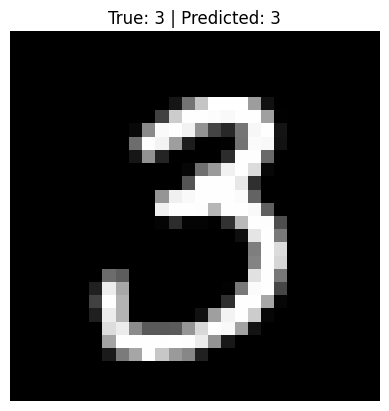

(3, 3)

In [22]:
predict_single_image(test_images, test_labels_oh, 90)

In [23]:
import pandas as pd

# Connects to the database
conn = sqlite3.connect("training_log.db")

# Loads the entire table into a Pandas DataFrame
df = pd.read_sql_query("SELECT * FROM training_log", conn)

# Closes the connection
conn.close()

# Displays the entire DataFrame
pd.set_option('display.max_rows', None)  # Shows all rows
pd.set_option('display.max_columns', None)  # Shows all columns
pd.set_option('display.width', None)  
pd.set_option('display.colheader_justify', 'center')

print(df)

    epoch  avg_cost  accuracy  precision   recall      f1   
0      1   0.603579   0.2779   0.170816   0.266784  0.196688
1      2   0.428847   0.3129   0.182235   0.301333  0.211761
2      3   0.410929   0.3358   0.195193   0.324009  0.228787
3      4   0.397078   0.3588   0.213390   0.346633  0.249939
4      5   0.385418   0.3806   0.229412   0.367930  0.272672
5      6   0.374573   0.4068   0.255187   0.393401  0.298093
6      7   0.363669   0.4287   0.287244   0.414783  0.318018
7      8   0.352745   0.4435   0.315625   0.429248  0.331603
8      9   0.342491   0.4571   0.333861   0.442628  0.344917
9     10   0.333228   0.4719   0.352359   0.457205  0.363124
10    11   0.323917   0.4992   0.383492   0.484228  0.400230
11    12   0.312809   0.5266   0.406852   0.511451  0.428965
12    13   0.302004   0.5428   0.426711   0.527486  0.444258
13    14   0.292982   0.5556   0.448769   0.540221  0.455907
14    15   0.285353   0.5622   0.485125   0.546782  0.463041
15    16   0.278709   0.